# Changes in Sleep Distribution Under Varied Pollutant Concentrations

In [4]:
# Common Libraries
import os
import math

# Data Science Libraries
import pandas as pd
import numpy as np
import scipy
from scipy import stats

# Visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Analysis Functions

In [5]:
def label_high(row,col,val):
    '''
    Returns a string based on the value of the column in a row 
    '''
    if row[col] > val:
        return 'high'
    else:
        return 'low'

## Data Import

In [7]:
df_py2 = pd.read_csv('/Users/hagenfritz/Projects/utx000_old/studies/cohort1/processed_data/study_sensirion_sleepstats',parse_dates=True,index_col=0)
df_py2['inc%'] = (df_py2['max'] - df_py2['min'])/df_py2['min']
df_py2['delta'] = df_py2['max'] - df_py2['min']
df_py2.head()

,ID,var,mean,median,max,min,std,inc%,delta
sleep_day,,,,,,,,,
2020-01-23,332b3bxa,Temperature [C],24.028501,24.050697,24.383156,23.662163,0.224960,0.030470,0.720993
2020-02-01,332b3bxa,Temperature [C],23.219098,23.117416,24.522011,21.990540,0.718377,0.115116,2.531471
2020-02-12,332b3bxa,Temperature [C],26.743766,26.700996,28.305870,26.196304,0.412137,0.080529,2.109566
2020-02-22,332b3bxa,Temperature [C],26.952201,26.954681,27.379265,26.490044,0.191550,0.033568,0.889221
2020-03-03,332b3bxa,Temperature [C],28.708112,28.701073,29.163040,28.220413,0.276476,0.033402,0.942627


In [8]:
df_py2['var'].unique()

array(['Temperature [C]', 'Relative Humidity', 'CO2', 'PM_N_0p5',
       'PM_N_1', 'PM_N_2p5', 'PM_N_4', 'PM_N_10', 'PM_C_1', 'PM_C_2p5',
       'PM_C_4', 'PM_C_10'], dtype=object)

In [9]:
df_py3 = pd.read_csv('/Users/hagenfritz/Projects/utx000_old/studies/cohort1/processed_data/study_adafruit_sleepstats',parse_dates=True,index_col=0)
df_py3['inc%'] = (df_py3['max'] - df_py3['min'])/df_py3['min']
df_py3['delta'] = df_py3['max'] - df_py3['min']
df_py3.head()

,ID,var,mean,median,max,min,std,inc%,delta
sleep_day,,,,,,,,,
2020-01-23,332b3bxa,eCO2,400.0,400.0,400.0,400.0,0.0,0.0,0.0
2020-02-01,332b3bxa,eCO2,400.0,400.0,400.0,400.0,0.0,0.0,0.0
2020-02-12,332b3bxa,eCO2,400.0,400.0,400.0,400.0,0.0,0.0,0.0
2020-02-22,332b3bxa,eCO2,400.0,400.0,400.0,400.0,0.0,0.0,0.0
2020-03-03,332b3bxa,eCO2,400.0,400.0,400.0,400.0,0.0,0.0,0.0


In [10]:
df_ss = pd.read_csv('/Users/hagenfritz/Projects/utx000_old/studies/cohort1/processed_data/study_sleepStagesDay.csv',parse_dates=True,index_col=0)
df_ss.head()

,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TotalTimeAwake,TotalMinutesLight,TotalMinutesDeep,TotalMinutesREM,Efficiency,Awake%,Light%,Deep%,REM%,Non-REM%,REM/nREM,TotalHoursAsleep,ID
SleepDay,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9l7wmsc3
2020-01-23,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9l7wmsc3
2020-01-24,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9l7wmsc3
2020-01-25,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9l7wmsc3
2020-01-26,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9l7wmsc3


## Analysis

Getting the overall dataframe that contains sleep and pollution metric data

In [11]:
results_df = pd.DataFrame()
var = 'CO2'
low_cutoffs = [0,0,0]
high_cutoffs = [1000000,1000,100]

# Masking by variables - still has all participants
if var in df_py2['var'].unique():
    print('2')
    df_py2_byvar = df_py2[df_py2['var'] == var]
else:
    print('3')
    df_py2_byvar = df_py3[df_py3['var'] == var]

# Looping through all the statistics - skipping over the ID and var columns
for column in df_py2_byvar.columns:
    if column in ['ID','var']:
        continue

    # Looping through all the participants
    overall = pd.DataFrame()
    for pid in df_py2_byvar['ID'].unique():
        dep_vars_ind = df_py2_byvar[df_py2_byvar['ID'] == pid]
        indep_vars_ind = df_ss[df_ss['ID'] == pid]
        indep_vars_ind.drop(['ID'],axis=1,inplace=True)
        combined = pd.concat([dep_vars_ind,indep_vars_ind],join='inner',axis=1)

        # Removing data where the efficiency is less than zero
        combined = combined[combined['Efficiency'] > 0]

        if len(combined) > 0:
            overall = pd.concat([overall,combined])

2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Doing some quick analysis to determine breakpoints

In [12]:
std = np.mean(overall['std'])
avg = np.mean(overall['mean'])
ps = overall['ID'].unique()
print(f'Mean: {avg}')
print(f'STD: {std}')
print(f'Participants: {len(ps)}')

Mean: 1153.2205980756396
STD: 73.92123441768663
Participants: 16


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


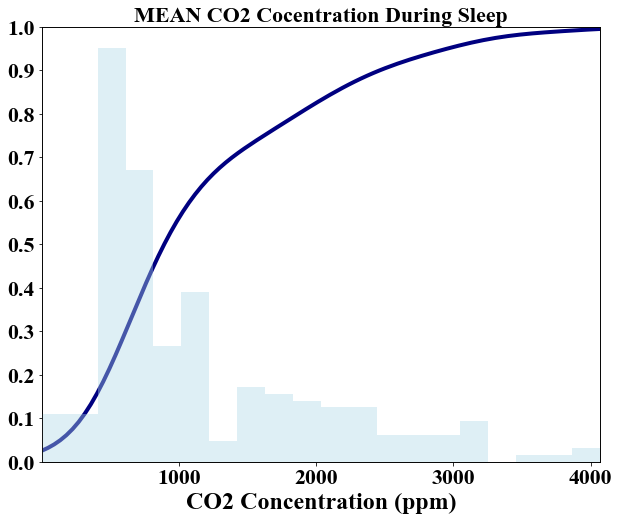

Median Value: 792.4882710774741


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


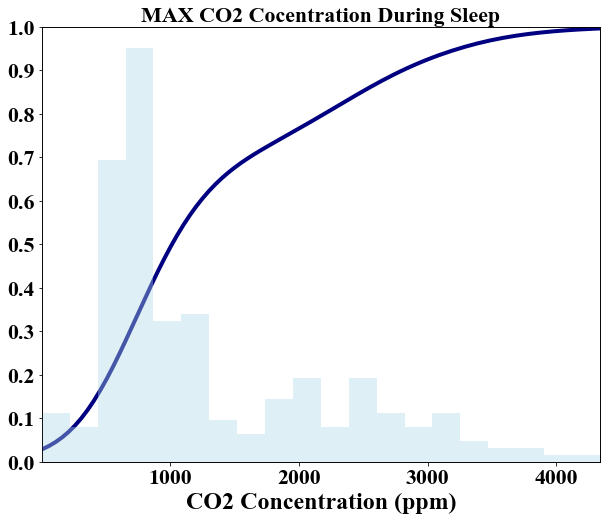

Median Value: 901.5161743164062


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


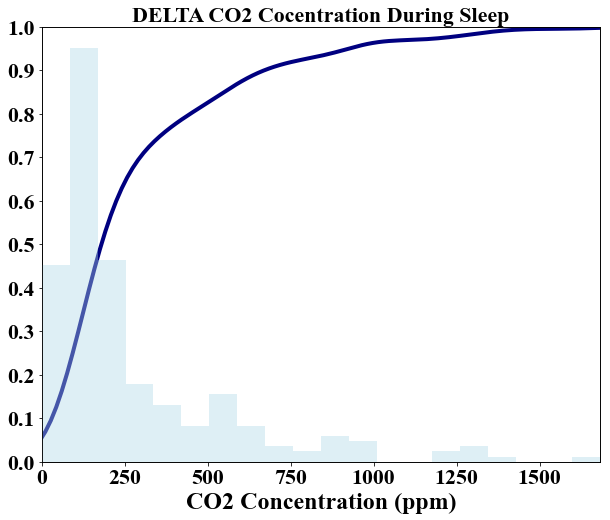

Median Value: 164.25021362304688


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


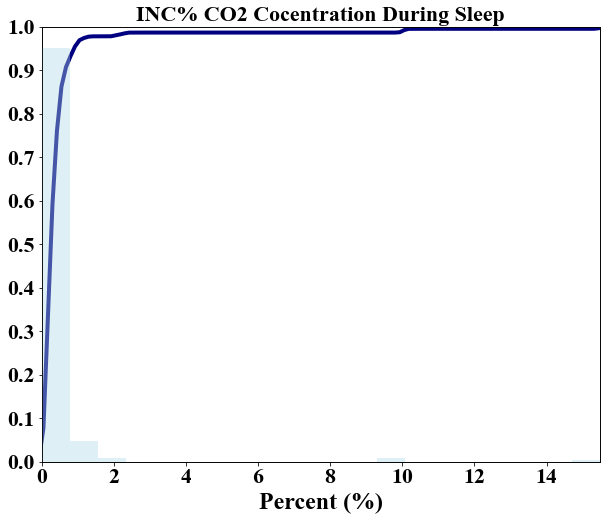

Median Value: 0.23063522387828997


In [17]:
columns = ['mean','max','delta','inc%']
if var == 'CO2':
    labels = ['CO2 Concentration (ppm)','CO2 Concentration (ppm)','CO2 Concentration (ppm)','Percent (%)']
    cutoffs = [600,1000,0.25]
    labels_v = [f'Mean ({cutoffs[0]} ppm)',f'Max ({cutoffs[1]} ppm)',f'Percent Increase ({cutoffs[2]}%)']
elif var == 'PM_C_2p5':
    labels = ['PM2.5 Concentration ($\mu$g/m$^3$)','PM2.5 Concentration ($\mu$g/m$^3$)','PM2.5 Concentration ($\mu$g/m$^3$)','Percent (%)']
    cutoffs = [6,12,10]
    labels_v = [f'Mean - {cutoffs[0]} $\mu$g/m$^3$ Threshold',f'Max - {cutoffs[1]} $\mu$g/m$^3$ Threshold',f'Percent Increase - {cutoffs[2]}% Threshold']
elif var == 'PM_C_10':
    labels = ['PM10 Concentration ($\mu$g/m$^3$)','PM10 Concentration ($\mu$g/m$^3$)','PM10 Concentration ($\mu$g/m$^3$)','Percent (%)']
    cutoffs = [12,35,10]
    labels_v = [f'Mean - {cutoffs[0]} $\mu$g/m$^3$ Threshold',f'Max - {cutoffs[1]} $\mu$g/m$^3$ Threshold',f'Percent Increase - {cutoffs[2]}% Threshold']
elif var == 'TVOC':
    labels = ['TVOC Concentration (ppb)','TVOC Concentration (ppb)','TVOC Concentration (ppb)','Percent (%)']
    cutoffs = [100,200,10]
    labels_v = [f'Mean - {cutoffs[0]} ppb Threshold',f'Max - {cutoffs[1]} ppb Threshold',f'Percent Increase - {cutoffs[2]}% Threshold']
elif var == 'NO2':
    labels = ['NO2 Concentration (ppb)','NO2 Concentration (ppb)','NO2 Concentration (ppb)','Percent (%)']
    cutoffs = [53,100,10]
    labels_v = [f'Mean - {cutoffs[0]} ppb Threshold',f'Max - {cutoffs[1]} ppb Threshold',f'Percent Increase - {cutoffs[2]}% Threshold']
elif var == 'CO':
    labels = ['CO Concentration (ppm)','CO Concentration (ppm)','CO Concentration (ppm)','Percent (%)']
    cutoffs = [1.5,3,10]
    labels_v = [f'Mean ({cutoffs[0]} ppm)',f'Max ({cutoffs[1]} ppm)',f'Percent Increase ({cutoffs[2]}%)']
    
for column,label in zip(columns,labels):
    nightly_pollutant_stats = overall

    # histrogram
    fig, ax = plt.subplots(figsize=(10,8))
    sns.kdeplot(nightly_pollutant_stats[column],color='navy',linewidth=4,cumulative=True,ax=ax,label='_nolegend_')
    ax2 = ax.twinx()
    sns.distplot(nightly_pollutant_stats[column],bins=20,kde=False,color='lightblue',ax=ax2,label='_nolegend_')
    ax2.set_yticks([], [])
    ax.set_xlabel(label)
    ax.set_xlim([min(nightly_pollutant_stats[column]),max(nightly_pollutant_stats[column])])
    ax.set_ylim([0,1])
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_title(f"{column.upper()} {var.upper()} Cocentration During Sleep")
    plt.savefig(f'../reports/figures/bpeace1_histogram_{column}{var}')

    plt.show()
    plt.close()
    
    print(f'Median Value: {np.median(nightly_pollutant_stats[column])}')

Cutoff points based on ASHRAE standards and median values

## Visualizing

In [15]:
tnrfont = {'fontname':'Times New Roman'}

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

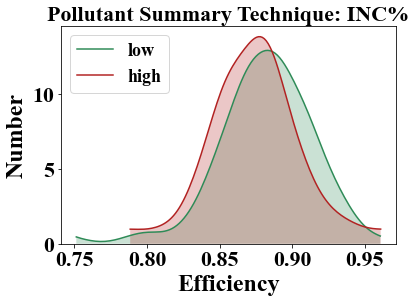

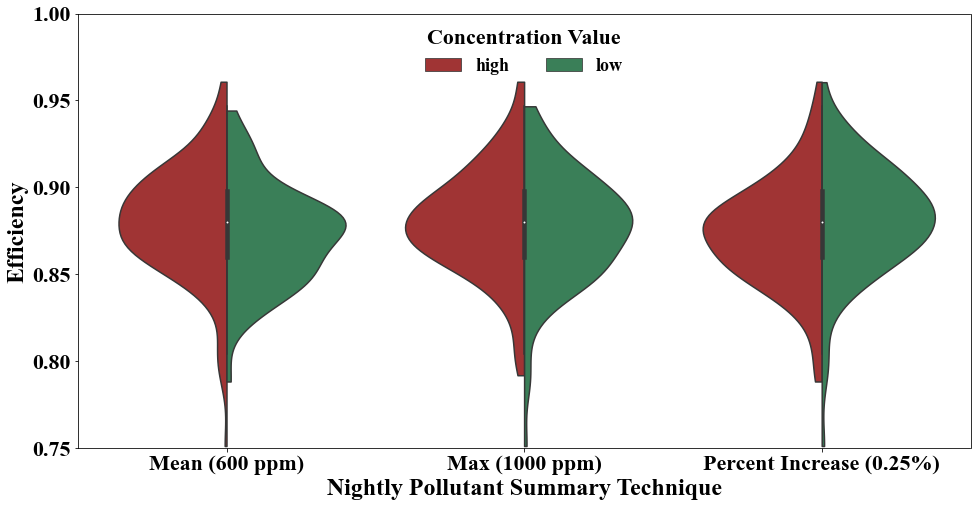

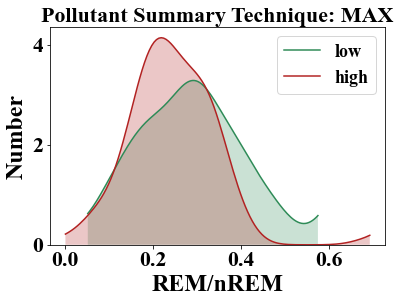

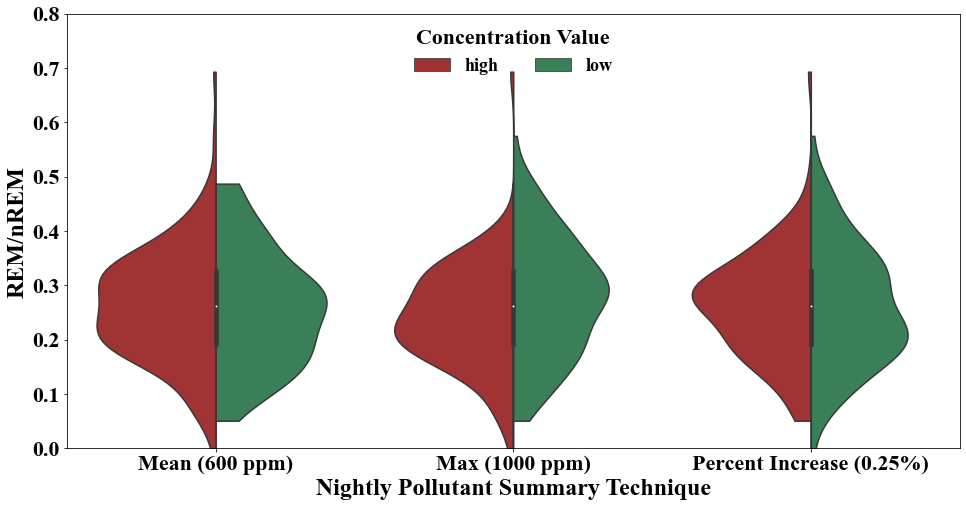

In [20]:
# Setting up
ylims = ([0.75,1],[0,0.8])
sleep_metrics = ['Efficiency','REM/nREM']

# Looping through the different sleep metrics to define high and low
summary = pd.DataFrame()
for sleep_metric,ylim in zip(sleep_metrics,ylims):

    nightly_summary = overall
    p_metrics = ['mean','max','inc%']
    df = pd.DataFrame()
    for p_metric,cutoff in zip(p_metrics,cutoffs):
        temp = pd.DataFrame(data={'Day':nightly_summary.index,
                                  'pollutant_metric':[p_metric]*len(nightly_summary),'pollutant_val':nightly_summary[p_metric],
                                  'sleep_metric':[sleep_metric]*len(nightly_summary),'sleep_val':nightly_summary[sleep_metric],})

        temp['cutoff'] = nightly_summary.apply(lambda row: label_high(row,p_metric,cutoff), axis=1)
        df = pd.concat([df,temp])
        
        nightly_summary_low = temp[temp["cutoff"] == 'low']
        nightly_summary_high = temp[temp["cutoff"] == 'high']
        statistic, p = stats.ttest_ind(nightly_summary_low['sleep_val'].values,nightly_summary_high['sleep_val'].values,nan_policy='omit')
        significance = False
        if p < 0.05:
            significance = True

        summary_temp = pd.DataFrame(data={'pollutant_metric':[p_metric],'cutoff':[cutoff],'sleep_metric':[sleep_metric],
                                'no_low':[len(nightly_summary_low)],'no_high':[len(nightly_summary_high)],
                                'mean_low':[np.mean(nightly_summary_low['sleep_val'])],'std_low':[np.std(nightly_summary_low['sleep_val'])],
                                'mean_high':[np.mean(nightly_summary_high['sleep_val'])],'std_high':[np.std(nightly_summary_high['sleep_val'])],
                                'p':[p],'significant':significance})
        summary = pd.concat([summary,summary_temp])
        
        if significance:
            fig, ax = plt.subplots()
            sns.kdeplot(data=nightly_summary_low['sleep_val'].values,shade=True,cut=0,color='seagreen',ax=ax, label='low')
            sns.kdeplot(data=nightly_summary_high['sleep_val'].values,shade=True,cut=0,color='firebrick',ax=ax, label='high')
            ax.set_xlabel(sleep_metric)
            ax.set_ylabel('Number')
            ax.set_title(f'Pollutant Summary Technique: {p_metric.upper()}')
            ax.legend()
            if '/' in sleep_metric:
                plt.savefig(f'../reports/figures/bpeace1_kdeplot_sig{var}_{p_metric[:-1].upper()}andREM2nREM.pdf')
            else:
                plt.savefig(f'../reports/figures/bpeace1_kdeplot_sig{var}_{p_metric[:-1].upper()}and{sleep_metric.upper()}.pdf')
            
            plt.show()
            plt.close()
    
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax = sns.violinplot(y='sleep_val', x='pollutant_metric', hue='cutoff',
                        data=df, palette={'high':'firebrick','low':'seagreen'}, split=True, cut=0)

    ax.set_ylabel(sleep_metric)
    ax.set_ylim(ylim)
    ax.set_xlabel('Nightly Pollutant Summary Technique')
    a=ax.get_xticks().tolist()
    for i in range(len(labels_v)):
        a[i] = labels_v[i]
    ax.set_xticklabels(a)
    ax.legend(ncol=2,loc='upper center',title='Concentration Value',frameon=False)
    if '/' in sleep_metric:
        plt.savefig(f'../reports/figures/bpeace1_violin_REM2nREMvs{var}.pdf')
    else:
        plt.savefig(f'../reports/figures/bpeace1_violin_{sleep_metric.upper()}vs{var}.pdf')

    plt.show()
    plt.close()
    
summary.to_csv(f'../data/processed/bpeace2_analysis_sleepvsco2_ttest.csv')
    

In [19]:
summary

,pollutant_metric,cutoff,sleep_metric,no_low,no_high,mean_low,std_low,mean_high,std_high,p,significant
0,mean,600.00,Efficiency,70,161,0.872161,0.028293,0.880521,0.032261,0.062935,False
0,max,1000.00,Efficiency,119,112,0.876184,0.032021,0.879903,0.030502,0.369708,False
0,inc%,0.25,Efficiency,122,109,0.881889,0.031824,0.873621,0.030216,0.045599,True
0,mean,600.00,REM/nREM,70,161,0.258206,0.106169,0.263257,0.102975,0.740181,False
0,max,1000.00,REM/nREM,119,112,0.278724,0.109008,0.242251,0.094367,0.009647,True
0,inc%,0.25,REM/nREM,122,109,0.262071,0.109119,0.261223,0.098350,0.952319,False
